# Least Squares Regression

Here I try to solve the least squares problem with pseudo-inverse and gradient descent. I compare the two approaches and highlight any key insights.

## Setup

Suppose I have data that exhibit linear relationship with measurement noise.

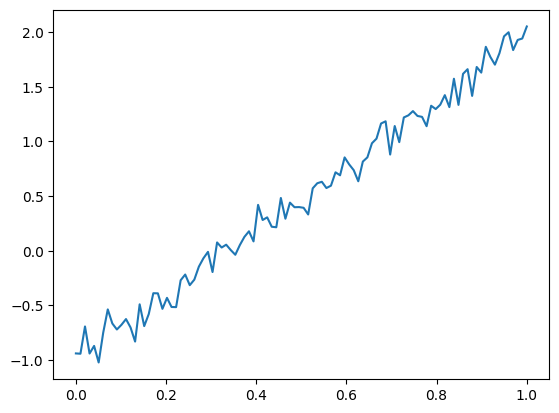

In [1]:
import numpy as np
from matplotlib import pyplot as plt

N = 100 # Number of data points
x = np.linspace(0, 1, N)
true_slope = 3.0
true_intercept = -1.0
noise = np.random.normal(0, 0.1, N)
y = true_slope * x + true_intercept + noise
plt.plot(x, y)

I want to fit a linear model with two parameters $a$ and $b$ to these data points.

$$
ax + b = y
$$

We will represent our input data `x` as a matrix and our parameters as a vector.

$$
X\vec{w} =
\begin{bmatrix}
x_0 & 1 \\
x_1 & 1 \\
\dots & 1 \\
x_{N-1} & 1 
\end{bmatrix}
\begin{bmatrix} a \\ b \end{bmatrix} =
\begin{bmatrix}
a x_0 + b \\
a x_1 + b \\
\dots \\
a x_{N-1} + b
\end{bmatrix} =
\begin{bmatrix} y_0 \\ y_1 \\ \dots \\ y_{N-1} \end{bmatrix} = \vec{y}
$$

## Approach 1: Normal Equations

We can solve for parameters using normal equations which can be derived from least squares loss.

$$
\begin{aligned}
L(\vec{w}) &= \frac{1}{2N}(X\vec{w} - \vec{y})^\intercal (X\vec{w} - \vec{y}) \\
&= \frac{1}{2N}((X\vec{w})^\intercal - y^\intercal) (X\vec{w} - \vec{y}) \\
&= \frac{1}{2N}(X\vec{w})^\intercal X\vec{w} - (X\vec{w})^\intercal y - y^\intercal(X\vec{w}) + y^\intercal y \\
&= \frac{1}{2N} \vec{w}^\intercal X^\intercal X\vec{w} - 2(X\vec{w})^\intercal y + y^\intercal y
\end{aligned} 
$$

When we take the derivative of the loss and find where slope is 0.

$$
\frac{\partial L}{\partial \vec{w}} = 2X^\intercal X\vec{w} - 2X^\intercal y = 0
$$

We can see that.

$$
X^\intercal X \vec{w} = X^\intercal y
$$

Thus,

$$
(X^\intercal X)^{-1}X^\intercal X \vec{w} = \vec{w} = (X^\intercal X)^{-1} X^\intercal y
$$

Fitted params [ 2.9507537  -0.99465013]


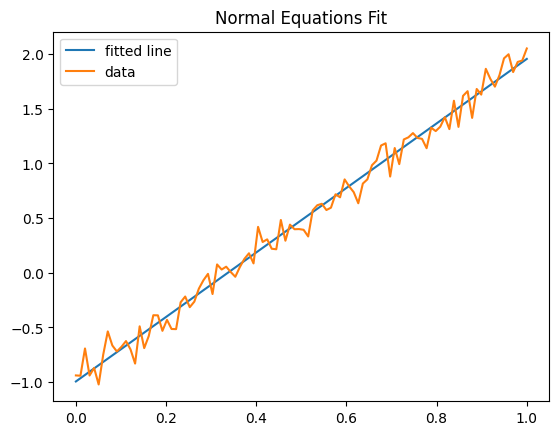

In [2]:
def normal_equations_fit(x, y):
    X = np.vstack([x, np.ones_like(x)]).T
    return np.linalg.inv(X.T @ X) @ X.T @ y


params = normal_equations_fit(x, y)
print("Fitted params", params)
plt.plot(x, x * params[0] + params[1], label="fitted line")
plt.plot(x, y, label="data")
plt.title("Normal Equations Fit")
plt.legend()

We can also add regularization to avoid overfitting.

$$
w = (X^\intercal X + \lambda I)^{-1} X^\intercal y
$$

When $X^\intercal X$ is not invertible, $X^\intercal X + \lambda I$ is invertible. However, if the number of features exceeds the number of observations, $X^T X$ is not invertible, even with the regularization term. It's best to use **pseudo inverse** in those cases.

Fitted params [ 2.93062432 -0.9840934 ]


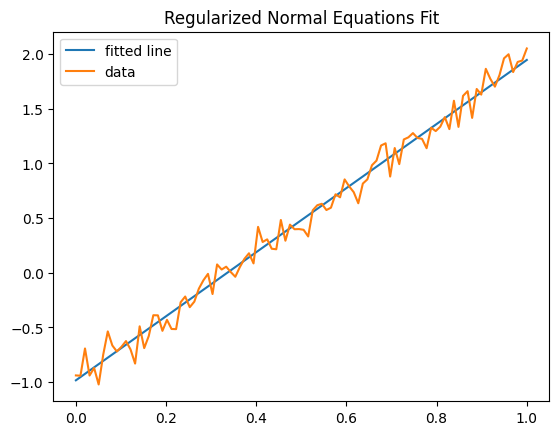

In [3]:
def regularized_normal_equations_fit(x, y, lambda_reg):
    X = np.vstack([x, np.ones_like(x)]).T
    N, D = X.shape
    return np.linalg.inv(X.T @ X + np.eye(D) * lambda_reg) @ X.T @ y


params = regularized_normal_equations_fit(x, y, 0.05)
print("Fitted params", params)
plt.plot(x, x * params[0] + params[1], label="fitted line")
plt.plot(x, y, label="data")
plt.title("Regularized Normal Equations Fit")
plt.legend()

## Approach 2: Pseudo-Inverse via Matrix Decomposition

We can solve for $\vec{w}$ by taking the inverse of $X$.

$$
X^{-1}X\vec{w} = \vec{w} = X^{-1}\vec{y}
$$

But $X$ is not a square matrix, it is not regular and it does not have a true inverse. We need to use **Moore-Penrose inverse** to perform a "pseudo-inverse". We will perform a singular decomposition on $X$.

$$
X = USV^\intercal
$$

Since $X$ is not a square matrix, its singular values will have 0's on its diagonal.

In [4]:
# Transform x into X matrix.
X = np.vstack([x, np.ones_like(x)]).T
X[:5]

array([[0.        , 1.        ],
       [0.01010101, 1.        ],
       [0.02020202, 1.        ],
       [0.03030303, 1.        ],
       [0.04040404, 1.        ]])

In [5]:
U, s, V_t = np.linalg.svd(X)
print("U", U.shape)
print("V transposed", V_t.shape)
print("Singular Values", s)

# Transform singular values into S matrix of shape (100, 2)
S = np.zeros((U.shape[1], V_t.shape[0]))
S[:2, :2] = np.diag(s)
print("S", S.shape)

# Verify that SVD worked: matmul on decomposed matrices should yield back X.
assert np.allclose(U @ S @ V_t, X)

U (100, 100)
V transposed (2, 2)
Singular Values [11.26040461  2.58939599]
S (100, 2)


Pseudo-inverse is defined as follows.

$$
X^{-1} = VS^{-1}U^\intercal
$$

Because

$$
X^{-1}X = I = VS^{-1}U^\intercal USV^\intercal
$$

$V$ and $U$ are orthogonal. By definition,

$$
V^\intercal V = VV^\intercal = I
$$

$$
U^\intercal U = U U^\intercal = I
$$

Therefore,

$$
X^{-1}X = I = VS^{-1}U^\intercal USV^\intercal = VS^{-1}SV^\intercal = VV^\intercal = I
$$

In [6]:
S_inv = np.zeros((U.shape[1], V_t.shape[0]))
S_inv[:2, :2] = np.diag(s)
S_inv[S != 0] = 1 / S[S != 0] # Perform inverse on this diagonal matrix

X_inv = (V_t.T @ S_inv.T @ U.T)

# Verify that pseudo inverse worked: X^-1 X should give identity matrix (2, 100)(100, 2) => (2, 2)
assert np.allclose(np.round(X_inv @ X, 5), np.eye(2))

Now we can use the pseudo inverse to solve for $\vec{w}$.

In [7]:
params = X_inv @ y
params

array([ 2.9507537 , -0.99465013])

In [8]:
y_pred = X @ params
y_pred.shape

(100,)

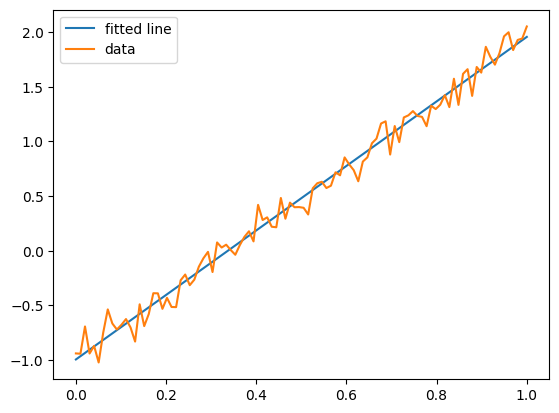

In [9]:
plt.plot(x, y_pred, label="fitted line")
plt.plot(x, y, label="data")
plt.legend()

Let's clean it up.

Fitted params [ 2.9507537  -0.99465013]


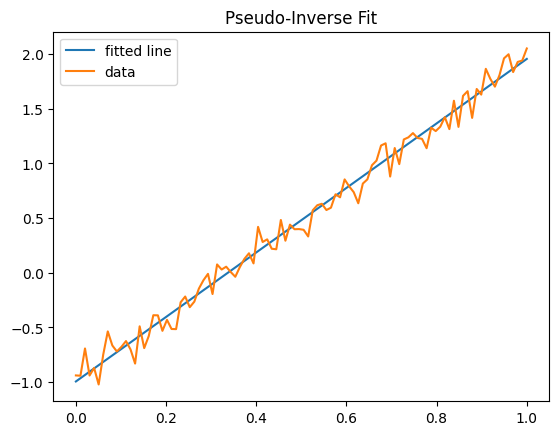

In [10]:
def pseudo_inverse_fit(x, y):
    X = np.vstack([x, np.ones_like(x)]).T
    # Let N be number of samples, D be number of parameters to fit
    N, D = X.shape
    U, s, V_t = np.linalg.svd(X)
    # Take reciprocal of singular values
    s = 1 / s
    S_inv = np.zeros((N, D))
    S_inv[:D, :D] = np.diag(s)
    X_inv = (V_t.T @ S_inv.T @ U.T)
    return X_inv @ y


params = pseudo_inverse_fit(x, y)
print("Fitted params", params)
plt.plot(x, X @ pseudo_inverse_fit(x, y), label="fitted line")
plt.plot(x, y, label="data")
plt.title("Pseudo-Inverse Fit")
plt.legend()

Regularization can be added by regularizing the singular values.

Fitted params [ 2.93062432 -0.9840934 ]


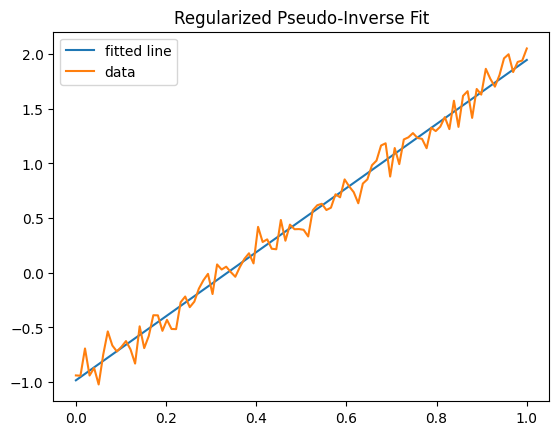

In [11]:
def regularized_pseudo_inverse_fit(x, y, lambda_reg):
    X = np.vstack([x, np.ones_like(x)]).T
    # Let N be number of samples, D be number of parameters to fit
    N, D = X.shape
    U, s, V_t = np.linalg.svd(X, full_matrices=False)
    # Add regularization term to singular values
    s = s / (s**2 + lambda_reg)
    S_inv = np.diag(s)
    X_inv = (V_t.T @ S_inv @ U.T)
    return X_inv @ y


params = regularized_pseudo_inverse_fit(x, y, 0.05)
print("Fitted params", params)
plt.plot(x, X @ params, label="fitted line")
plt.plot(x, y, label="data")
plt.title("Regularized Pseudo-Inverse Fit")
plt.legend()

## Aproach 2: Gradient Descent

SVD can be quite expensive for big dataset because it has $O(NM^2)$ time complexity for matrix $\mathbb{R}^{N \times M}$. The alternative is to take an iterative approach using gradient descent.

$$
L(\vec{w}) = \frac{1}{2N}\Sigma (\vec{x}_i \vec{w} - \vec{y}_i)^2
$$

The gradient of loss with respect to $L$ is

$$
\frac{\partial L}{\partial \vec{w}} = \frac{1}{N}\Sigma x_i (\vec{x}_i \vec{w} - \vec{y}_i) = \frac{1}{N} X^\intercal (X\vec{w} - \vec{y})
$$

Fitted params [ 2.86148884 -0.94566096]


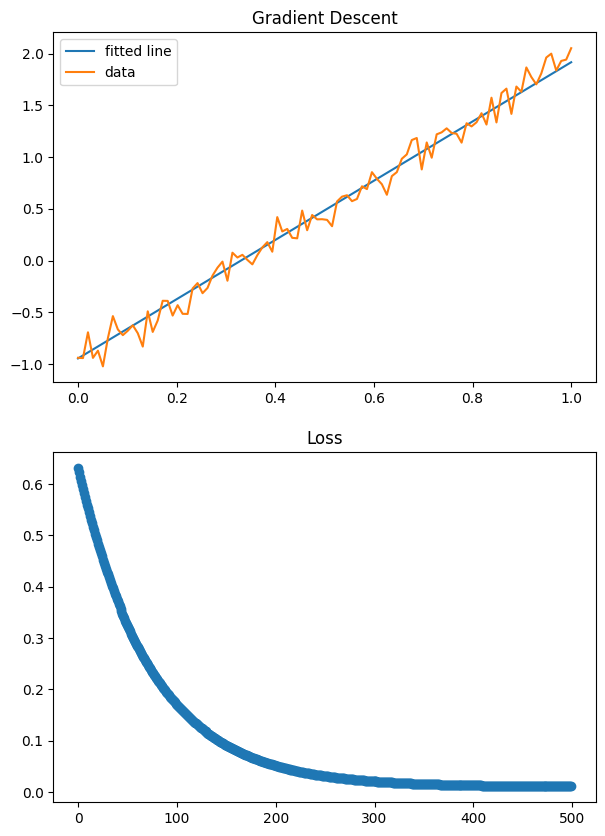

In [12]:
def gradient_descent(x, y, epochs=1, batch_size=20, learning_rate=1e-3):
    X = np.vstack([x, np.ones_like(x)]).T
    N, D = X.shape
    w = np.random.randn(D, 1)
    losses = []
    for ep in range(epochs):
        for i in range(N // batch_size):
            start = i * batch_size
            end = (i + 1) * batch_size
            batch_x = X[start:end, :] # (B, D)
            batch_y = np.expand_dims(y[start:end], axis=-1) # (B, 1)

            pred = batch_x @ w # (B, D)(D, 1) => (B, 1)
            error = pred - batch_y # (B, 1)
            grad_w = batch_x.T @ error # (D, B)(B ,1) => (D, 1) same shape as w
            w -= learning_rate * grad_w
        
        loss = np.sum((X @ w - np.expand_dims(y, axis=-1))**2) / N
        losses.append(loss)
    return np.squeeze(w), losses


params, losses = gradient_descent(x, y, epochs=500, batch_size=20, learning_rate=1e-3)
print("Fitted params", params)
_, axs = plt.subplots(2, figsize=(7, 10))
axs[0].set_title("Gradient Descent")
axs[0].plot(x, X @ params, label="fitted line")
axs[0].plot(x, y, label="data")
axs[0].legend()
axs[1].set_title("Loss")
axs[1].plot(losses, 'o-')

Now add L2 regularization to the gradient descent logic.

$$
\frac{\partial L}{\partial \vec{w}} = \frac{1}{N}\Sigma x_i (\vec{x}_i \vec{w} - \vec{y}_i) + 2*\lambda \Sigma w_j = \frac{1}{N} X^\intercal (X\vec{w} - \vec{y}) + 2*\lambda \vec{w}
$$

Fitted params [ 2.57303149 -0.79237891]


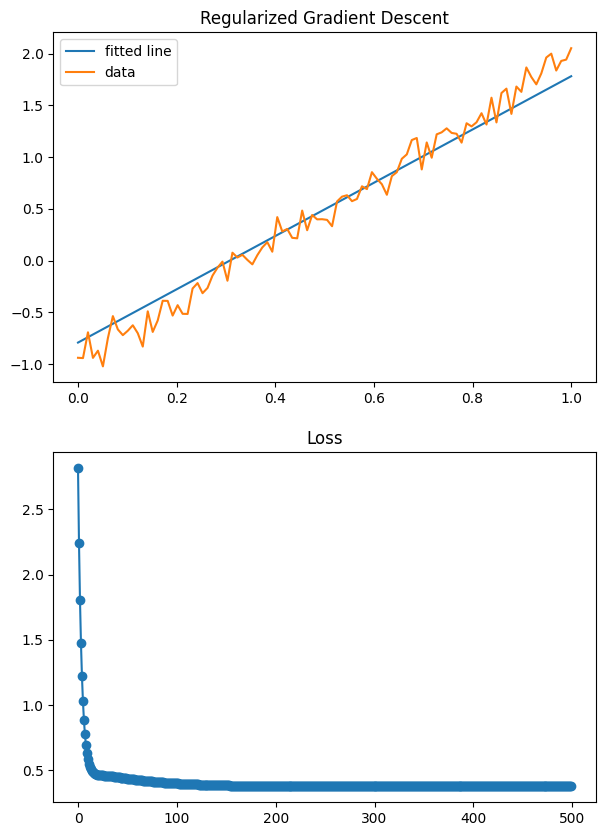

In [13]:
def regularized_gradient_descent(x, y, epochs=10, batch_size=10, learning_rate=1e-2, reg=1e-1):
    X = np.vstack([x, np.ones_like(x)]).T
    N, D = X.shape
    w = np.random.randn(D, 1)
    losses = []
    for ep in range(epochs):
        for i in range(N // batch_size):
            start = i * batch_size
            end = (i + 1) * batch_size
            batch_x = X[start:end, :] # (B, D)
            batch_y = np.expand_dims(y[start:end], axis=-1) # (B, 1)

            pred = batch_x @ w # (B, D)(D, 1) => (B, 1)
            error = pred - batch_y # (B, 1)
            grad_w = batch_x.T @ error + reg * w # (D, B)(B ,1) => (D, 1) same shape as w
            w -= learning_rate * grad_w
        
        loss = np.sum((X @ w - np.expand_dims(y, axis=-1))**2) / N + reg * np.sum(w)
        losses.append(loss)
    return np.squeeze(w), losses


params, losses = regularized_gradient_descent(x, y, epochs=500, batch_size=20, learning_rate=1e-3, reg=2e-1)
print("Fitted params", params)
_, axs = plt.subplots(2, figsize=(7, 10))
axs[0].set_title("Regularized Gradient Descent")
axs[0].plot(x, X @ params, label="fitted line")
axs[0].plot(x, y, label="data")
axs[0].legend()
axs[1].set_title("Loss")
axs[1].plot(losses, 'o-')